In [ ]:
!pip install -qq transformers

     |████████████████████████████████| 1.1MB 6.7MB/s 
     |████████████████████████████████| 3.0MB 22.8MB/s 
     |████████████████████████████████| 1.1MB 40.2MB/s 
     |████████████████████████████████| 890kB 46.8MB/s 


In [ ]:
import pandas as pd
import numpy as np
import re
from transformers import BertModel, BertTokenizer, AdamW
import torch
from torch import nn
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
from functools import reduce
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

# Params
data_name = 'ST'
drop_out = 0.3
seed = 0
n_folds = 5
model_name = 'bert-base-cased'
batch_size = 32
device = 'cuda'
n_classes = 3
n_epochs = 10
lr = 5e-5
note = 'deduplicated'

In [ ]:
# Randomly sampled and labeled tweets. set this path accordingly
# 'tweet' - column having tweets
# 'Label' - column having labels

data_whole = pd.read_csv('/content/drive/My Drive/CSCW_H1/data/ST_labeled.csv')

In [ ]:
def anyalnum(string):
  return any(char.isalnum() for char in string)

def preprocess(tweet):
  tweet = tweet.replace('@ ','@').replace('# ','#')
  tweet = re.sub('pic.twitter.com.*','',tweet)
  tweet = re.sub('https*://[^\s]+','',tweet)
  tweet = re.sub('https*://.*','',tweet)
  # tweet = ' '.join(word for word in tweet.split() if anyalnum(word))
  return tweet

data_whole['processed_tweet'] = data_whole['tweet'].apply(preprocess)
data = data_whole.drop_duplicates('processed_tweet').reset_index(drop=True)
data.sample(1)

,tweet,Label,cashtags,conversation_id,created_at,date,day,favorites,geo,has_media,hashtags,hour,id,img_urls,is_replied,is_reply_to,likes,link,links,mentions,name,near,nlikes,nreplies,nretweets,parent_tweet_id,place,quote_url,replies,reply_to,reply_to_users,retweet,retweet_date,retweet_id,retweets,screen_name,search,source,text_html,timestamp_epochs,timezone,trans_dest,trans_src,translate,tweet_id,user_id,user_id_str,user_rt,user_rt_id,username,video_url,lang,ZLabel,TLabel,RLabel,"(45, 'ZLabel')","(35, 'ZLabel')","(67, 'RLabel')","(76, 'RLabel')","(90, 'TLabel')","(148, 'TLabel')",processed_tweet
281,request all the eminent agencies to implement ...,2,NaN,NaN,NaN,2018-06-15 21:28,NaN,1.0,NaN,NaN,NaN,NaN,1.010000e+18,NaN,NaN,NaN,NaN,https://twitter.com/laxmissingh/status/1007653...,NaN,@ @ @ @ @ @,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,laxmissingh,NaN,en,2.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,request all the eminent agencies to implement ...


In [ ]:
print('number of tweets', len(data_whole))
print('number of deduplicated tweets', len(data_whole.drop_duplicates('tweet')))
print('number of deduplicated tweets after processing', len(data))
data.Label.value_counts()

number of tweets 516
number of deduplicated tweets 446
number of deduplicated tweets after processing 430


2    285
1     82
0     63
Name: Label, dtype: int64

In [ ]:
tokenizer = BertTokenizer.from_pretrained(model_name)
# find max length of tokenized sequence
max_len = 0
for each in data.processed_tweet:
  tmp_len = tokenizer.tokenize(each)
  if max_len < len(tmp_len):
    max_len = len(tmp_len)
print(max_len)


114


In [ ]:
class DatasetClass(Dataset):
  def __init__(self, tweets, labels, tokenizer, max_len):
    self.tweets = tweets
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.tweets)

  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    label = self.labels[item]
    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation = True,
    )
    return {
      'tweet_text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(label, dtype=torch.long)
    }

def create_data_loader(df, index, tokenizer, max_len, batch_size):
  tmp_df = df.loc[index]
  data = DatasetClass(
    tweets=tmp_df.processed_tweet.to_numpy(),
    labels=tmp_df.Label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    data,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
data_dict = {i:{'train':None, 'test':None, 'val':None} for i in range(n_folds)}
splitter = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
for fold, (train_val_ind, test_ind) in enumerate(splitter.split(data.index)):
  train_ind, val_ind = train_test_split(train_val_ind, random_state=seed, test_size=0.20)
  data_dict[fold]['train'] = create_data_loader(data, train_ind, tokenizer, max_len, batch_size)
  data_dict[fold]['val'] = create_data_loader(data, val_ind, tokenizer, max_len, batch_size)
  data_dict[fold]['test'] = create_data_loader(data, test_ind, tokenizer, max_len, batch_size)

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes, drop_out):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(model_name)
    self.drop = nn.Dropout(p=drop_out)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(output)
    return self.out(output)

## Extract last hidden state of first token as per
http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/

In [ ]:
torch.manual_seed(seed)
embed_dict = {i:{'train_X':None,'val_X':None,'test_X':None,'train_y':None,'val_y':None,'test_y':None} for i in range(n_folds)}
model = SentimentClassifier(n_classes, drop_out).to(device)
model.eval()
for fold in range(n_folds):
  train_data = data_dict[fold]['train']
  train_embeds = []
  train_labels = []
  val_data = data_dict[fold]['val']
  val_embeds = []
  val_labels = []
  test_data = data_dict[fold]['test']
  test_embeds = []
  test_labels = []
  # Train
  for batch in train_data:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    train_labels.append(batch["labels"])
    train_embeds.append(model.bert(input_ids, attention_mask)[0][:,0,:].cpu().detach().numpy())
    # Val
  for batch in val_data:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    val_labels.append(batch["labels"])
    val_embeds.append(model.bert(input_ids, attention_mask)[0][:,0,:].cpu().detach().numpy())
    # Test
  for batch in test_data:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    test_labels.append(batch["labels"])
    test_embeds.append(model.bert(input_ids, attention_mask)[0][:,0,:].cpu().detach().numpy())
  embed_dict[fold]['train_X'] = np.concatenate(train_embeds)
  embed_dict[fold]['val_X'] = np.concatenate(val_embeds)
  embed_dict[fold]['test_X'] = np.concatenate(test_embeds)
  embed_dict[fold]['train_y'] = np.concatenate(train_labels)
  embed_dict[fold]['val_y'] = np.concatenate(val_labels)
  embed_dict[fold]['test_y'] = np.concatenate(test_labels)
  print(embed_dict[fold]['train_X'].shape, embed_dict[fold]['val_X'].shape, embed_dict[fold]['test_X'].shape)
  print(embed_dict[fold]['train_y'].shape, embed_dict[fold]['val_y'].shape, embed_dict[fold]['test_y'].shape)
print(embed_dict[fold]['test_X'][-1][-1]) # -0.006914719
pd.to_pickle(embed_dict, '/content/drive/My Drive/CSCW_H1/data/embeds_ST.pickle')

# This will be used in training classifiers with BERT


(275, 768) (69, 768) (86, 768)
(275,) (69,) (86,)
(275, 768) (69, 768) (86, 768)
(275,) (69,) (86,)
(275, 768) (69, 768) (86, 768)
(275,) (69,) (86,)
(275, 768) (69, 768) (86, 768)
(275,) (69,) (86,)
(275, 768) (69, 768) (86, 768)
(275,) (69,) (86,)
0.18970275


In [ ]:
torch.manual_seed(seed)

model = SentimentClassifier(n_classes, drop_out)
model = model.to(device)
init_state = model.state_dict()
optimizer = AdamW(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss().to(device)

train_outs = {i:{'pred_y':[],'y':[],'loss':[]} for i in range(n_folds)}
val_outs = {i:{'pred_y':[],'y':[],'loss':[],'optim_epoch':None,'optim_loss':None} for i in range(n_folds)}

for fold in range(n_folds):
  torch.cuda.empty_cache()
  model.load_state_dict(init_state)

  train_data = data_dict[fold]['train']
  val_data = data_dict[fold]['val']
  global_val_loss = np.inf

  for epoch in range(n_epochs):
    # Training
    model.train()
    train_epoch_loss = []
    for batch in train_data:
      optimizer.zero_grad()

      outputs = model(batch["input_ids"].to(device),
                      batch["attention_mask"].to(device),
      )
      _, preds = torch.max(outputs, dim=1)

      train_outs[fold]['pred_y'].extend(preds.detach().cpu().tolist())
      train_outs[fold]['y'].extend(batch["labels"].tolist())
      
      loss = loss_fn(outputs, batch["labels"].to(device))
      train_epoch_loss.append(loss.item())
      loss.backward()
      optimizer.step()
    print('Train','fold=',fold,'iter=',epoch,'loss=',np.mean(train_epoch_loss))
    train_outs[fold]['loss'].append(np.mean(train_epoch_loss))

    # Validation
    model.eval()
    val_epoch_loss = []
    for batch in val_data:

      outputs = model(batch["input_ids"].to(device),
                      batch["attention_mask"].to(device),
      )
      _, preds = torch.max(outputs, dim=1)

      val_outs[fold]['pred_y'].extend(preds.detach().cpu().tolist())
      val_outs[fold]['y'].extend(batch["labels"].tolist())
      
      loss = loss_fn(outputs, batch["labels"].to(device))
      val_epoch_loss.append(loss.item())
    mean_val_loss = np.mean(val_epoch_loss)
    val_outs[fold]['loss'].append(mean_val_loss)
    if mean_val_loss < global_val_loss:
      torch.save(model.state_dict(), '/content/model'+str(fold))
      val_outs[fold]['optim_epoch'] = epoch
      val_outs[fold]['optim_loss'] = mean_val_loss
      global_val_loss = mean_val_loss
    print('Val','fold=',fold,'iter=',epoch,'loss=',mean_val_loss,
          'optim_loss=',global_val_loss,'optim_epoch=',val_outs[fold]['optim_epoch'])


Train fold= 0 iter= 0 loss= 1.039557033114963
Val fold= 0 iter= 0 loss= 0.8966018557548523 optim_loss= 0.8966018557548523 optim_epoch= 0
Train fold= 0 iter= 1 loss= 0.8646749390496148
Val fold= 0 iter= 1 loss= 0.8534972667694092 optim_loss= 0.8534972667694092 optim_epoch= 1
Train fold= 0 iter= 2 loss= 0.7601465119255914
Val fold= 0 iter= 2 loss= 0.8005946079889933 optim_loss= 0.8005946079889933 optim_epoch= 2
Train fold= 0 iter= 3 loss= 0.6009950041770935
Val fold= 0 iter= 3 loss= 0.7728976011276245 optim_loss= 0.7728976011276245 optim_epoch= 3
Train fold= 0 iter= 4 loss= 0.45713064405653214
Val fold= 0 iter= 4 loss= 1.0854260126749675 optim_loss= 0.7728976011276245 optim_epoch= 3
Train fold= 0 iter= 5 loss= 0.32052141262425315
Val fold= 0 iter= 5 loss= 0.9472914536794027 optim_loss= 0.7728976011276245 optim_epoch= 3
Train fold= 0 iter= 6 loss= 0.29912910362084705
Val fold= 0 iter= 6 loss= 1.1630102793375652 optim_loss= 0.7728976011276245 optim_epoch= 3
Train fold= 0 iter= 7 loss= 0.3

In [ ]:
# Testing
test_outs = {i:{'pred_proba':[], 'pred_y':[],'y':[]} for i in range(n_folds)}
model_dict = {i:None for i in range(n_folds)}
train_epoch_loss = []
for fold in range(n_folds):
  model.load_state_dict(torch.load('/content/model'+str(fold)))
  model.eval()
  test_data = data_dict[fold]['test']
  for batch in test_data:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    test_outs[fold]['pred_proba'].extend(outputs.detach().cpu().tolist())
    test_outs[fold]['pred_y'].extend(preds.detach().cpu().tolist())
    test_outs[fold]['y'].extend(batch["labels"].tolist())
    model_dict[fold] = model.state_dict()
  print('fold=',fold)

fold= 0
fold= 1
fold= 2
fold= 3
fold= 4


In [ ]:
test_pred_proba_all = reduce(lambda x,y: x+y, [test_outs[i]['pred_proba'] for i in range(n_folds)])
test_pred_y_all = reduce(lambda x,y: x+y, [test_outs[i]['pred_y'] for i in range(n_folds)])
test_y_all = reduce(lambda x,y: x+y, [test_outs[i]['y'] for i in range(n_folds)])
print(classification_report(test_y_all, test_pred_y_all))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90        63
           1       0.92      0.79      0.85        82
           2       0.94      0.99      0.96       285

    accuracy                           0.93       430
   macro avg       0.93      0.88      0.90       430
weighted avg       0.93      0.93      0.93       430



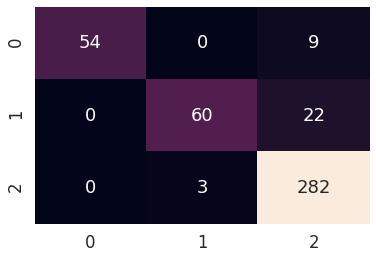

In [ ]:
sns.set(font_scale=1.5)
sns.heatmap(confusion_matrix(test_y_all, test_pred_y_all), 
            annot=True, cbar=False, fmt='g');

In [ ]:
final_dict = {'data_name':data_name,
              'seed':seed,
              'n_folds':n_folds,
              'model_name':model_name,
              'batch_size':batch_size,
              'drop_out':drop_out,
              'device':device,
              'n_classes':n_classes,
              'n_epochs':n_epochs,
              'lr':lr,
              'note':note,
              'train_outs':train_outs,
              'val_outs':val_outs,
              'test_outs':test_outs,
              'Classification_report':classification_report(test_y_all, test_pred_y_all)
              }
f_name = '_'.join(map(str,[data_name, seed, n_folds, model_name, batch_size, drop_out, device, n_classes, n_epochs, 
                           lr, note]))
pd.to_pickle(final_dict, '/content/drive/My Drive/CSCW_H1/results/'+f_name)
pd.to_pickle(model_dict, '/content/drive/My Drive/CSCW_H1/results/models_'+f_name)